In [11]:
import torch
from src.models.gnn import GCNRegressor, GATRegressor
import os
from tqdm import tqdm
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.data import Data
from generate_data import *
from src.datasets.dataset import ManifoldGraphDataset

architectures = {
    'gcn': GCNRegressor,
    'gat': GATRegressor
}

In [12]:
# Load the model
hidden_channels = 256
features_max_k = 201
num_layers = 10

# data parameters
subgraph_k = 5
degree_features = False
data_dir = 'data/manifolds_nbr_distances/'
data_files = os.listdir(data_dir)
print("Data files: ", data_files)

model_name = "gcn_2_23_nbr_distances_fmk_200_subgraph_k_5_num_layers_10"
arch = 'gcn'

model_path = f'outputs/{model_name}/nn/best_val.pt'
save_path = f'outputs/{model_name}/plots'
os.makedirs(save_path, exist_ok=True)

model = architectures[arch](
    features_max_k, 
    hidden_channels,
    num_layers,
    dropout=0.0
)
model.load_state_dict(torch.load(model_path))
model.eval()
print(model)

Data files:  ['torus_inrad_1_outrad_2_nodes_5000_k_10.pt', 'euclidean_dim_2_rad_2_nodes_5000_k_10.pt', 'sphere_dim_2_rad_2_nodes_5000_k_10.pt', 'poincare_K_-1_nodes_5000_k_10.pt', 'poincare_K_-2_nodes_5000_k_10.pt', 'sphere_dim_2_rad_1_nodes_5000_k_10.pt', 'hyperbolic_nodes_5000_k_10.pt']
GCNRegressor(
  (conv1): GCNConv(201, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 256)
  (conv4): GCNConv(256, 256)
  (conv5): GCNConv(256, 256)
  (conv6): GCNConv(256, 256)
  (conv7): GCNConv(256, 256)
  (conv8): GCNConv(256, 256)
  (conv9): GCNConv(256, 256)
  (conv10): GCNConv(256, 256)
  (lin): Linear(in_features=256, out_features=1, bias=True)
)


In [13]:
def get_data(data_dir, file):
    data = torch.load(os.path.join(data_dir, file))
    X, manifold_graph = data['coords'], data['graph']
    dataset = ManifoldGraphDataset(
        manifold_graph,
        subgraph_k=subgraph_k,
        degree_features=degree_features,
        subsample_pctg=1.0
    )
    subgraph_data = dataset.data
    return X, subgraph_data

def predict_curvature(model, subgraph_list):
    # for each node in graph, create subgraph and pass through GCN
    # return tuple of (features, curvature, predicted curvature)
    features = []
    curvatures = []
    predicted_curvatures = []

    for subgraph in tqdm(subgraph_list, desc="Predicting curvatures"):
        with torch.no_grad():
            x, edge_index, edge_attrs, batch = subgraph.x.float(), subgraph.edge_index, subgraph.edge_attr.float(), subgraph.batch
            pred = model(x, edge_index, edge_attrs, batch)
            features.append(subgraph.x)
            curvatures.append(subgraph.y)
            predicted_curvatures.append(pred)
    return features, curvatures, predicted_curvatures

Predicting curvatures: 100%|██████████| 5000/5000 [00:34<00:00, 145.94it/s]


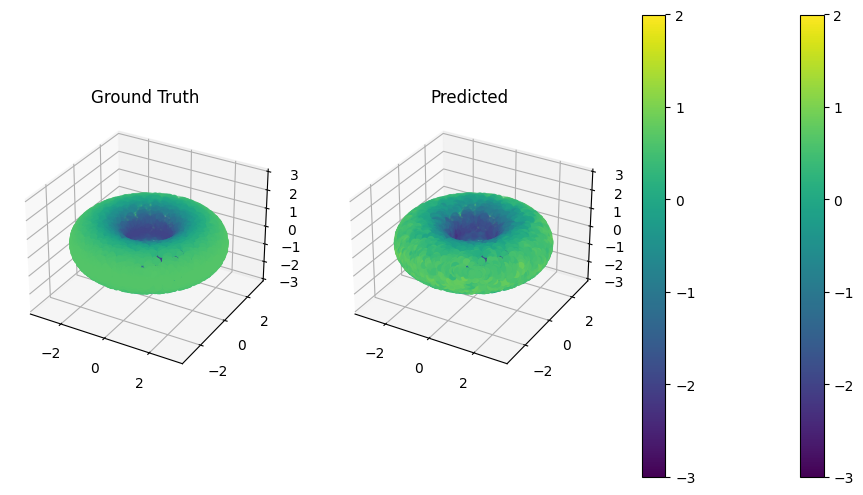

In [14]:
# # torus
torus_file = 'torus_inrad_1_outrad_2_nodes_5000_k_10.pt'
assert torus_file in data_files
X, subgraph_data = get_data(data_dir, torus_file)
features, curvatures, predicted_curvatures = predict_curvature(model, subgraph_data)
curvatures = torch.cat(curvatures, dim=0).numpy()
predicted_curvatures = torch.cat(predicted_curvatures, dim=0).squeeze(-1).numpy()

# # plot results
# # create two adjacent 3d subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})
axs[0].set_title('Ground Truth')
axs[1].set_title('Predicted')
axs[0].set_zlim(-3, 3)
axs[1].set_zlim(-3, 3)
p1 = axs[0].scatter(X[:, 0], X[:, 1], X[:, 2], 'o', c=curvatures.tolist())
p2 = axs[1].scatter(X[:, 0], X[:, 1], X[:, 2], 'o', c=predicted_curvatures.tolist())
fig.colorbar(p1, ax=axs.ravel().tolist())
fig.colorbar(p2, ax=axs.ravel().tolist())
p1.set_clim(-3, 2)
p2.set_clim(-3, 2)
plt.savefig(f'{save_path}/{torus_file}_pred.png')

Predicting curvatures: 100%|██████████| 5000/5000 [00:36<00:00, 135.50it/s]


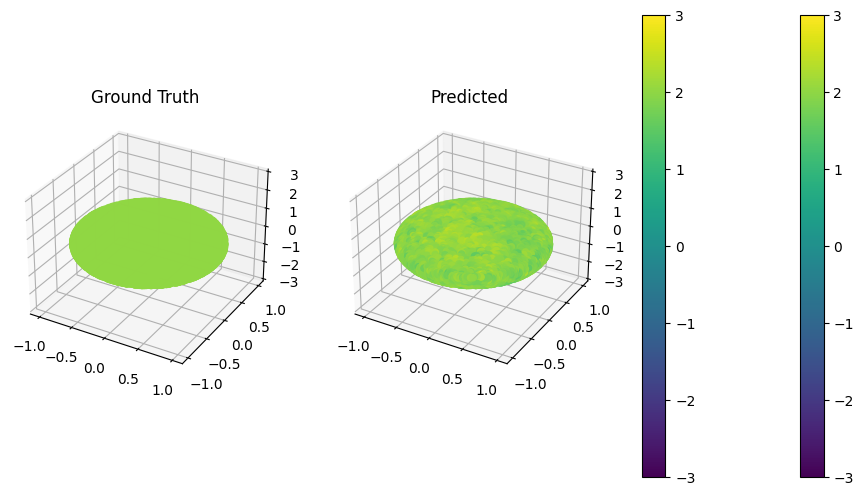

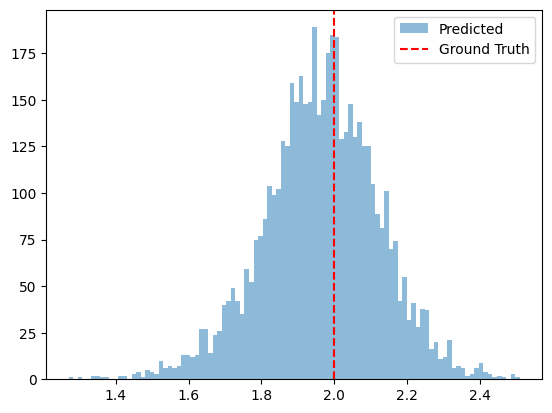

In [15]:
# sphere, r = 1
sphere_file = 'sphere_dim_2_rad_1_nodes_5000_k_10.pt'
assert sphere_file in data_files
X, subgraph_data = get_data(data_dir, sphere_file)
features, curvatures, predicted_curvatures = predict_curvature(model, subgraph_data)
curvatures = torch.cat(curvatures, dim=0).numpy()
predicted_curvatures = torch.cat(predicted_curvatures, dim=0).squeeze(-1).numpy()

# # plot results
# # create two adjacent 3d subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})
axs[0].set_title('Ground Truth')
axs[1].set_title('Predicted')
axs[0].set_zlim(-3, 3)
axs[1].set_zlim(-3, 3)
p1 = axs[0].scatter(X[:, 0], X[:, 1], X[:, 2], 'o', c=curvatures.tolist())
p2 = axs[1].scatter(X[:, 0], X[:, 1], X[:, 2], 'o', c=predicted_curvatures.tolist())
fig.colorbar(p1, ax=axs.ravel().tolist())
fig.colorbar(p2, ax=axs.ravel().tolist())
p1.set_clim(-3, 3)
p2.set_clim(-3, 3)
plt.savefig(f'{save_path}/{sphere_file}_pred.png')

# histogram
plt.figure()
plt.hist(predicted_curvatures, bins=100, alpha=0.5, label='Predicted')
plt.axvline(curvatures[0], color='r', linestyle='dashed', label='Ground Truth')
plt.legend(loc='upper right')
plt.savefig(f'{save_path}/{sphere_file}_hist.png')

Predicting curvatures: 100%|██████████| 5000/5000 [00:40<00:00, 122.91it/s]


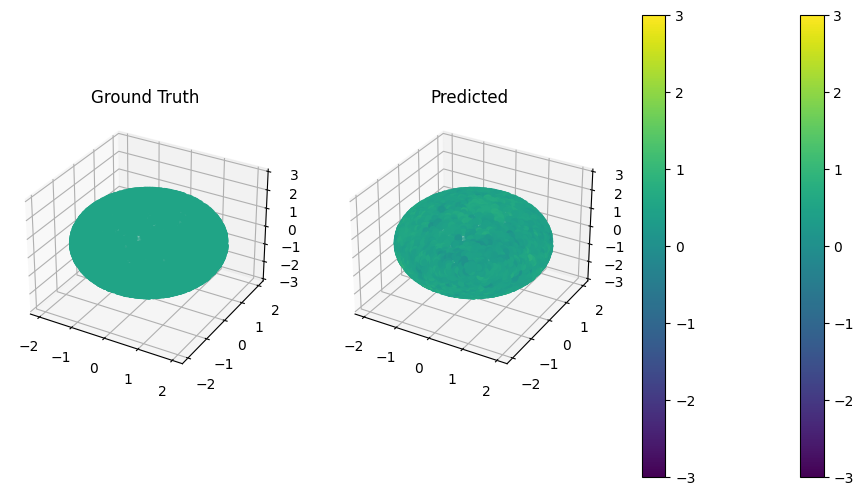

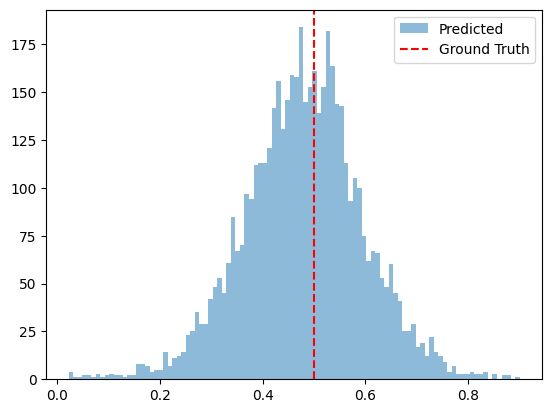

In [16]:
# sphere, r = 2
sphere_file = 'sphere_dim_2_rad_2_nodes_5000_k_10.pt'
assert sphere_file in data_files
X, subgraph_data = get_data(data_dir, sphere_file)
features, curvatures, predicted_curvatures = predict_curvature(model, subgraph_data)
curvatures = torch.cat(curvatures, dim=0).numpy()
predicted_curvatures = torch.cat(predicted_curvatures, dim=0).squeeze(-1).numpy()

# plot results
# create two adjacent 3d subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})
axs[0].set_title('Ground Truth')
axs[1].set_title('Predicted')
axs[0].set_zlim(-3, 3)
axs[1].set_zlim(-3, 3)
p1 = axs[0].scatter(X[:, 0], X[:, 1], X[:, 2], 'o', c=curvatures.tolist())
p2 = axs[1].scatter(X[:, 0], X[:, 1], X[:, 2], 'o', c=predicted_curvatures.tolist())
fig.colorbar(p1, ax=axs.ravel().tolist())
fig.colorbar(p2, ax=axs.ravel().tolist())
p1.set_clim(-3, 3)
p2.set_clim(-3, 3)
plt.savefig(f'{save_path}/{sphere_file}_pred.png')

# histogram
plt.figure()
plt.hist(predicted_curvatures, bins=100, alpha=0.5, label='Predicted')
plt.axvline(curvatures[0], color='r', linestyle='dashed', label='Ground Truth')
plt.legend(loc='upper right')
plt.savefig(f'{save_path}/{sphere_file}_hist.png')

Predicting curvatures: 100%|██████████| 5000/5000 [00:40<00:00, 124.28it/s]


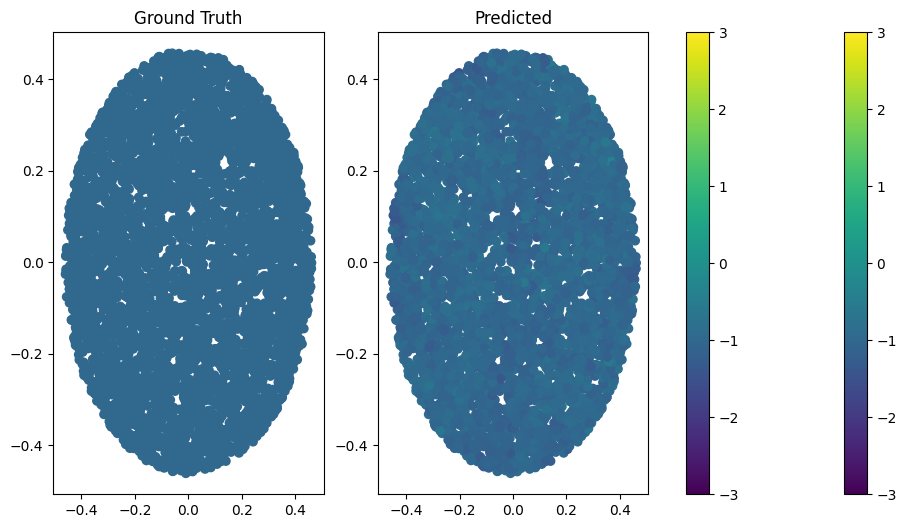

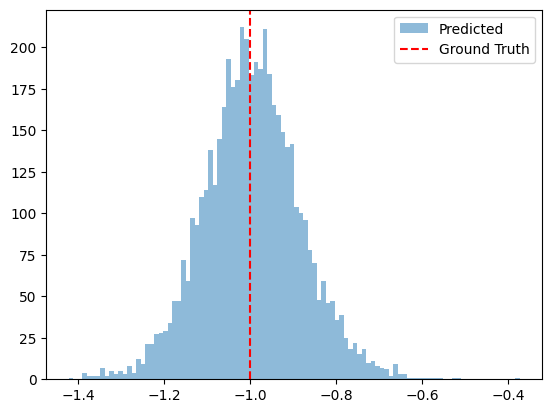

In [17]:
# poincare, K = -1
poincare_file = 'poincare_K_-1_nodes_5000_k_10.pt'
assert poincare_file in data_files
X, subgraph_data = get_data(data_dir, poincare_file)
features, curvatures, predicted_curvatures = predict_curvature(model, subgraph_data)
curvatures = torch.cat(curvatures, dim=0).numpy()
predicted_curvatures = torch.cat(predicted_curvatures, dim=0).squeeze(-1).numpy()

# # plot results
# # create two adjacent 2d subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].set_title('Ground Truth')
axs[1].set_title('Predicted')
p1 = axs[0].scatter(X[:, 0], X[:, 1], c=curvatures.tolist())
p2 = axs[1].scatter(X[:, 0], X[:, 1], c=predicted_curvatures.tolist())
fig.colorbar(p1, ax=axs.ravel().tolist())
fig.colorbar(p2, ax=axs.ravel().tolist())
p1.set_clim(-3, 3)
p2.set_clim(-3, 3)
plt.savefig(f'{save_path}/{poincare_file}_pred.png')

# histogram
plt.figure()
plt.hist(predicted_curvatures, bins=100, alpha=0.5, label='Predicted')
plt.axvline(curvatures[0], color='r', linestyle='dashed', label='Ground Truth')
plt.legend(loc='upper right')
plt.savefig(f'{save_path}/{poincare_file}_hist.png')


Predicting curvatures: 100%|██████████| 5000/5000 [00:43<00:00, 115.99it/s]


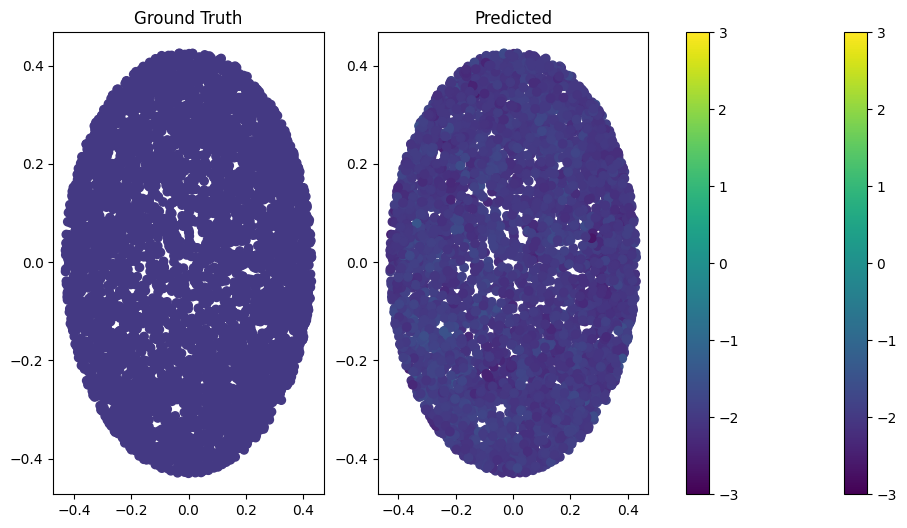

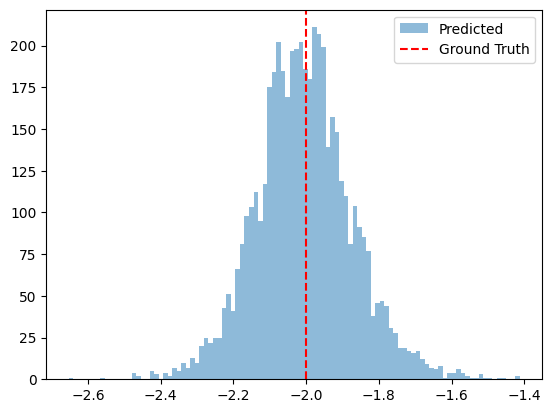

In [18]:
# poincare, K = -2
poincare_file = 'poincare_K_-2_nodes_5000_k_10.pt'
assert poincare_file in data_files
X, subgraph_data = get_data(data_dir, poincare_file)
features, curvatures, predicted_curvatures = predict_curvature(model, subgraph_data)
curvatures = torch.cat(curvatures, dim=0).numpy()
predicted_curvatures = torch.cat(predicted_curvatures, dim=0).squeeze(-1).numpy()

# # plot results
# # create two adjacent 2d subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].set_title('Ground Truth')
axs[1].set_title('Predicted')
p1 = axs[0].scatter(X[:, 0], X[:, 1], c=curvatures.tolist())
p2 = axs[1].scatter(X[:, 0], X[:, 1], c=predicted_curvatures.tolist())
fig.colorbar(p1, ax=axs.ravel().tolist())
fig.colorbar(p2, ax=axs.ravel().tolist())
p1.set_clim(-3, 3)
p2.set_clim(-3, 3)
plt.savefig(f'{save_path}/{poincare_file}_pred.png')

# histogram
plt.figure()
plt.hist(predicted_curvatures, bins=100, alpha=0.5, label='Predicted')
plt.axvline(curvatures[0], color='r', linestyle='dashed', label='Ground Truth')
plt.legend(loc='upper right')
plt.savefig(f'{save_path}/{poincare_file}_hist.png')


Predicting curvatures: 100%|██████████| 5000/5000 [00:42<00:00, 118.27it/s]


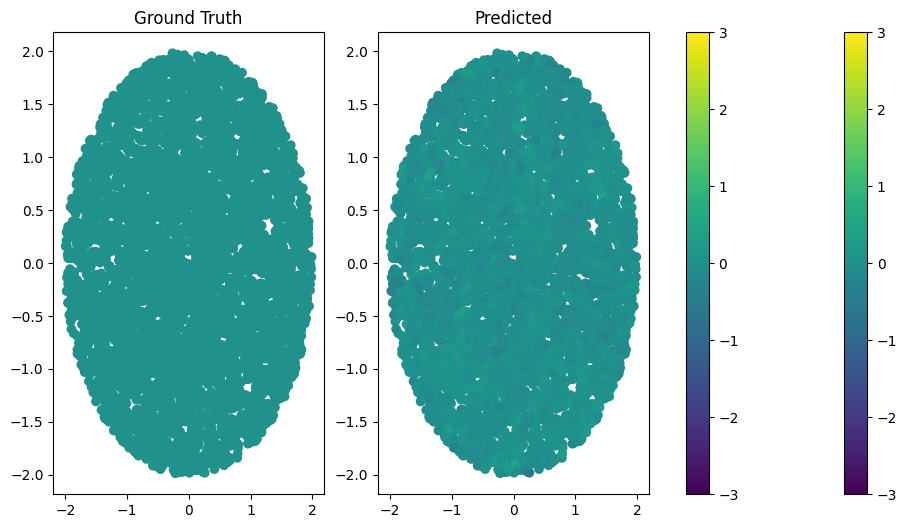

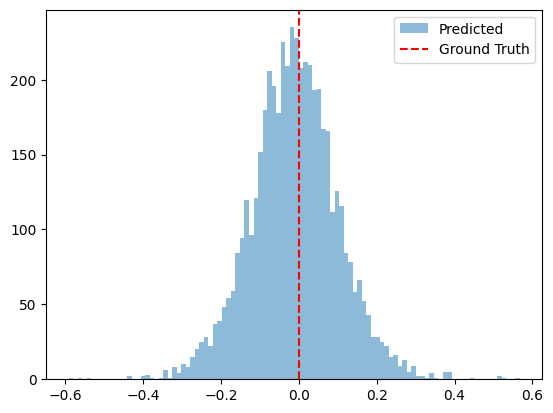

In [19]:
euclidean_file = 'euclidean_dim_2_rad_2_nodes_5000_k_10.pt'
assert euclidean_file in data_files
X, subgraph_data = get_data(data_dir, euclidean_file)
features, curvatures, predicted_curvatures = predict_curvature(model, subgraph_data)
curvatures = torch.cat(curvatures, dim=0).numpy()
predicted_curvatures = torch.cat(predicted_curvatures, dim=0).squeeze(-1).numpy()

# # plot results
# # create two adjacent 2d subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].set_title('Ground Truth')
axs[1].set_title('Predicted')
p1 = axs[0].scatter(X[:, 0], X[:, 1], c=curvatures.tolist())
p2 = axs[1].scatter(X[:, 0], X[:, 1], c=predicted_curvatures.tolist())
fig.colorbar(p1, ax=axs.ravel().tolist())
fig.colorbar(p2, ax=axs.ravel().tolist())
p1.set_clim(-3, 3)
p2.set_clim(-3, 3)
plt.savefig(f'{save_path}/{euclidean_file}_pred.png')

# histogram
plt.figure()
plt.hist(predicted_curvatures, bins=100, alpha=0.5, label='Predicted')
plt.axvline(curvatures[0], color='r', linestyle='dashed', label='Ground Truth')
plt.legend(loc='upper right')
plt.savefig(f'{save_path}/{euclidean_file}_hist.png')


Predicting curvatures: 100%|██████████| 5000/5000 [00:38<00:00, 131.05it/s]


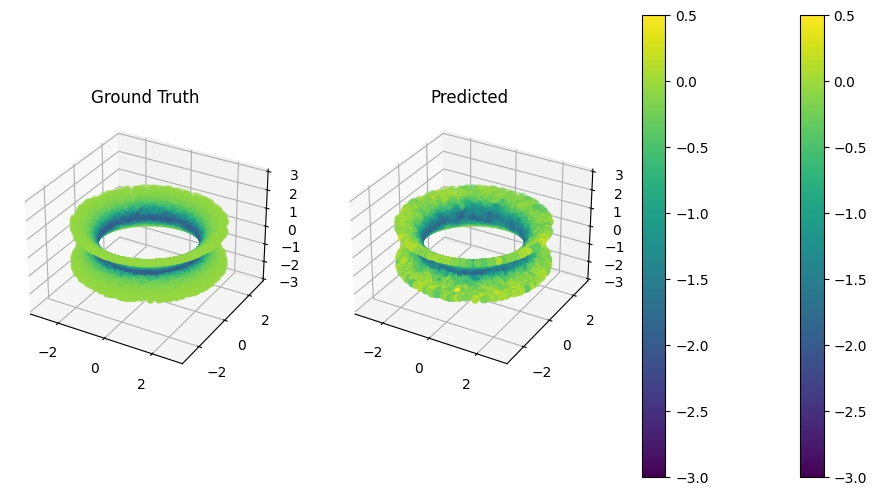

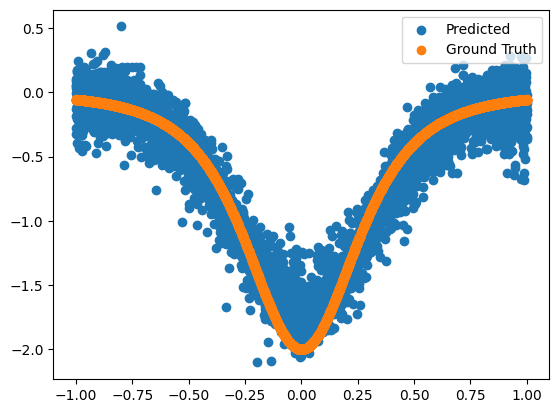

In [20]:
# generate new data
hyperboloid_file = 'hyperbolic_nodes_5000_k_10.pt'
assert hyperboloid_file in data_files
X, subgraph_data = get_data(data_dir, hyperboloid_file)
features, curvatures, predicted_curvatures = predict_curvature(model, subgraph_data)
curvatures = torch.cat(curvatures, dim=0).numpy()
predicted_curvatures = torch.cat(predicted_curvatures, dim=0).squeeze(-1).numpy()

# plot results
# create two adjacent 3d subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})
axs[0].set_title('Ground Truth')
axs[1].set_title('Predicted')
axs[0].set_zlim(-3, 3)
axs[1].set_zlim(-3, 3)
p1 = axs[0].scatter(X[:, 0], X[:, 1], X[:, 2], 'o', c=curvatures.tolist())
p2 = axs[1].scatter(X[:, 0], X[:, 1], X[:, 2], 'o', c=predicted_curvatures.tolist())
fig.colorbar(p1, ax=axs.ravel().tolist())
fig.colorbar(p2, ax=axs.ravel().tolist())
p1.set_clim(-3, 0.5)
p2.set_clim(-3, 0.5)
plt.savefig(f'{save_path}/{hyperboloid_file}_pred.png')


# histogram
plt.figure()
plt.scatter(X[:,2], predicted_curvatures, label='Predicted')
plt.scatter(X[:,2], curvatures, label='Ground Truth')
plt.legend(loc='upper right')
plt.savefig(f'{save_path}/{hyperboloid_file}_hist.png')
